# 1. Import Libraries

In [1]:
!pip install geopy
!pip install mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from geopy.distance import geodesic
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# 2. Load Dataset

In [2]:
df = pd.read_csv("C:\\Users\\NANNDITHA RAMESH\\Downloads\\amazon_delivery.csv")
print("Dataset Loaded Successfully!")



Dataset Loaded Successfully!


# 3. Data Cleaning

In [3]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)



# 4. Feature Engineering

In [4]:
# Calculate distance
def calculate_distance(row):
    store = (row['Store_Latitude'], row['Store_Longitude'])
    drop = (row['Drop_Latitude'], row['Drop_Longitude'])
    return geodesic(store, drop).km

df['Distance_km'] = df.apply(calculate_distance, axis=1)

# Extract time features
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Order_DayOfWeek'] = df['Order_Date'].dt.dayofweek
df['Order_Month'] = df['Order_Date'].dt.month

# Encode categorical variables
df = pd.get_dummies(df, columns=['Weather', 'Traffic', 'Vehicle', 'Area', 'Category'], drop_first=True)



# 5. Feature and Target

In [5]:
X = df.drop(['Order_ID', 'Delivery_Time', 'Order_Date', 'Order_Time', 'Pickup_Time',
             'Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], axis=1)
y = df['Delivery_Time']



# 6. Split Dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# 7. Initialize MLflow

In [7]:
mlflow.set_experiment("Amazon Delivery Time Prediction")

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

for name, model in models.items():
    with mlflow.start_run(run_name=name) as run:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

        mlflow.log_param("model_name", name)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

        # NEW: infer and log model signature
        from mlflow.models.signature import infer_signature
        signature = infer_signature(X_train, model.predict(X_train))

        mlflow.sklearn.log_model(model, "model", signature=signature)

        # 💥 PRINT RUN ID
        print(f"Run ID for {name}: {run.info.run_id}")

Linear Regression -> MAE: 26.31, RMSE: 33.31, R2: 0.58
Run ID for Linear Regression: 8608ac742fb748e58f44cef5f1c76afe
Random Forest -> MAE: 17.55, RMSE: 23.03, R2: 0.80
Run ID for Random Forest: 43e36eed66e44d55adf42d7c5f72fad3
Gradient Boosting -> MAE: 19.54, RMSE: 25.17, R2: 0.76
Run ID for Gradient Boosting: 693f28e9024c4bcf8e6a895ad73b4a73


# 8. Model Training and Tracking

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")

        mlflow.log_param("model_name", name)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)
        mlflow.sklearn.log_model(model, "model")

print("Training Completed and Tracked in MLflow!")
with mlflow.start_run(run_name=name) as run:
    ...
    print(f"Run ID for {name}: {run.info.run_id}")


Linear Regression -> MAE: 26.31, RMSE: 33.31, R2: 0.58


2025/04/28 07:43:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest -> MAE: 17.59, RMSE: 23.07, R2: 0.80


2025/04/28 07:44:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting -> MAE: 19.54, RMSE: 25.17, R2: 0.76


2025/04/28 07:44:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Completed and Tracked in MLflow!
Run ID for Gradient Boosting: 44455df1f5e9424a8afb21959e4fdac6


# 9. EDA (Simple)

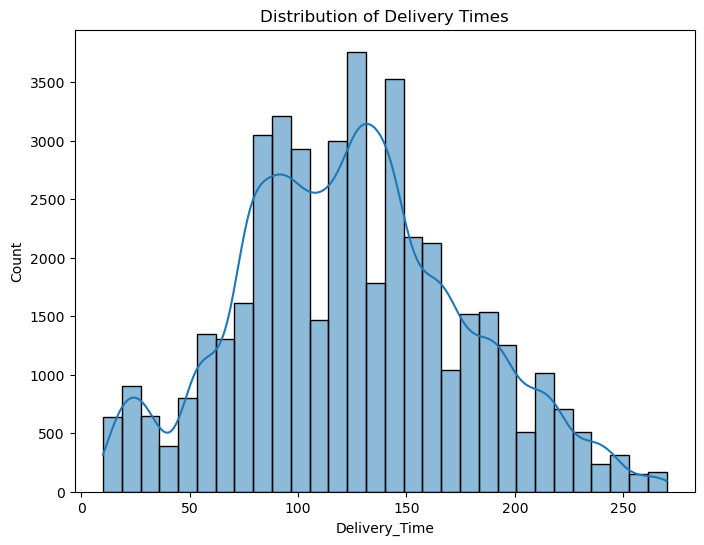

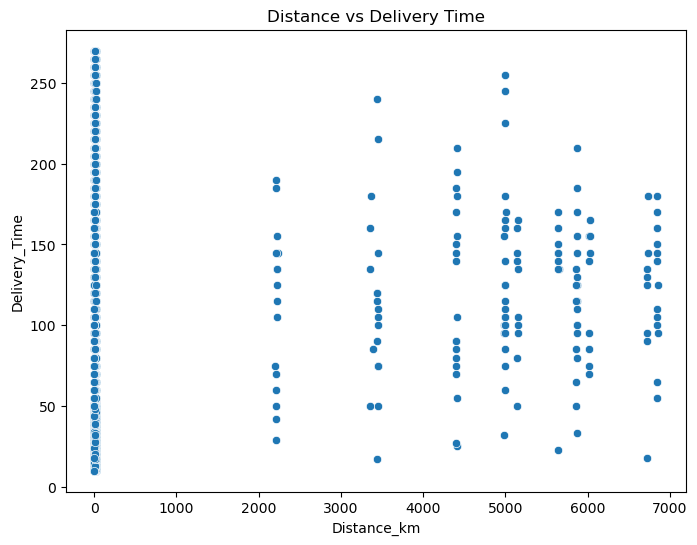

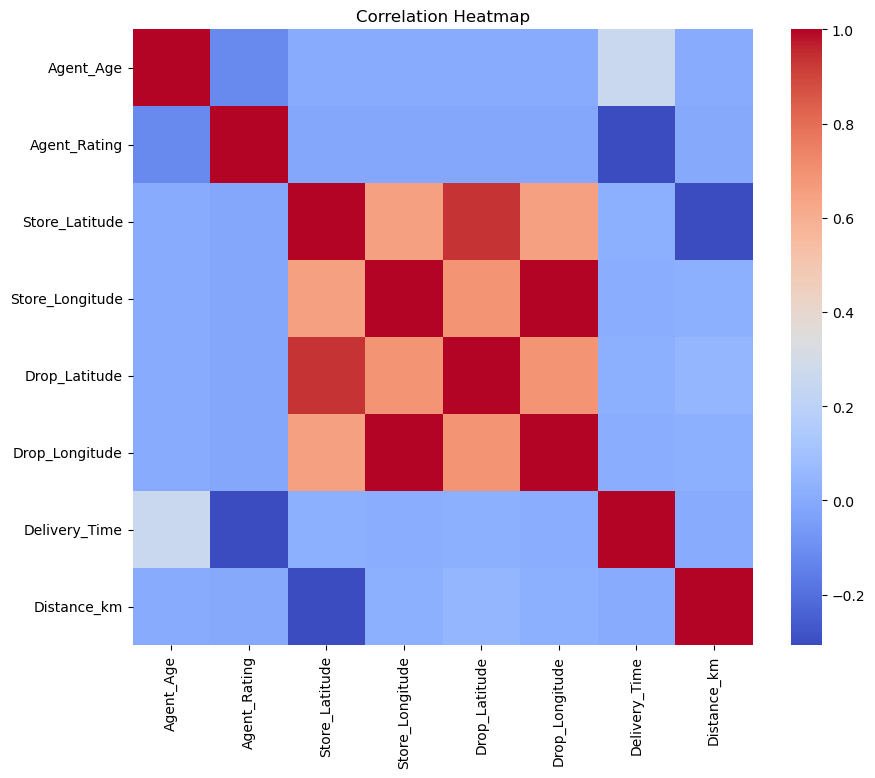

Run ID for Gradient Boosting: fb90d93a46de4ecdbec626c9effd12e0


In [9]:
plt.figure(figsize=(8,6))
sns.histplot(df['Delivery_Time'], kde=True, bins=30)
plt.title('Distribution of Delivery Times')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Distance_km'], y=df['Delivery_Time'])
plt.title('Distance vs Delivery Time')
plt.show()

plt.figure(figsize=(10,8))

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()
with mlflow.start_run(run_name=name) as run:
    ...
    print(f"Run ID for {name}: {run.info.run_id}")


In [15]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)
import joblib

# Save model
joblib.dump(random_forest_model, 'best_model.pkl')
print("✅ Model saved successfully!")

# Load model (for checking)
model = joblib.load('best_model.pkl')
print("✅ Model loaded successfully!")


✅ Model saved successfully!
✅ Model loaded successfully!
